In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import plotly.express as px
from datetime import datetime
from scipy.signal import argrelextrema

In [36]:
df = pd.read_csv("Nvidia.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Unnamed: 0"])
df.set_index("Date", inplace=True)

In [37]:
df.columns = ['Price','Volume','Timestamp']

In [38]:
def weekly_price(x):
    weekly_price = df[x].resample("W").mean()
    local_max_index = argrelextrema(weekly_price.values, np.greater)[0]
    local_min_index = argrelextrema(weekly_price.values, np.less)[0]
    local_max_prices = weekly_price.iloc[local_max_index]
    local_min_prices = weekly_price.iloc[local_min_index]

    fig = px.line(weekly_price, title=f"Biểu Đồ Biến Động {x} Hàng Tuần", labels={'index': 'Ngày', 'value': f'Giá {x} (USD)'})
    fig.add_scatter(x=local_max_prices.index, y=local_max_prices, mode='markers', name='Điểm Cao', marker_symbol='triangle-up', marker_color='red')
    fig.add_scatter(x=local_min_prices.index, y=local_min_prices, mode='markers', name='Điểm Thấp', marker_symbol='triangle-down', marker_color='green')

    fig.show()

In [39]:
weekly_price('Price')

In [40]:
df.head()

,Price,Volume,Timestamp
Date,,,
2019-02-04,37.30,52860000.0,1.549213e+09
2019-02-05,37.49,54240000.0,1.549300e+09
2019-02-06,38.25,70250000.0,1.549386e+09
2019-02-07,36.85,63710000.0,1.549472e+09
2019-02-08,37.04,46160000.0,1.549559e+09


In [41]:

df['Trading_value']=df['Price']*df['Volume']
df['Daily_Return'] = df['Price'].pct_change()
df['30D MA'] = df['Price'].rolling(30).mean()
df['60D MA'] = df['Price'].rolling(60).mean()
df['90D MA'] = df['Price'].rolling(90).mean()
df['Uper Band'] = df['Price'].rolling(30).mean() + 2*df['Price'].rolling(30).std()
df['Lower Band'] = df['Price'].rolling(30).mean() - 2*df['Price'].rolling(30).std()

In [42]:
def compute_rsi(data, window=18):
    delta = data['Price'].diff()
    gain = delta * 0
    loss = delta * 0

    gain[delta > 0] = delta[delta > 0]
    loss[delta < 0] = -delta[delta < 0]

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df, window=18)


In [43]:
daily_return_std = df['Daily_Return'].std()
df['Normalized_Volatility'] = df['Daily_Return'] / daily_return_std

Đường cam phía trên là uptrend đường cam phía dưới là dowmntrend

In [44]:
df_check_1=df[['Price','30D MA','60D MA','90D MA']]
fig = px.line(data_frame=df_check_1)
fig.show()

In [45]:
df_check_2=df[['Uper Band','Price','30D MA','60D MA','Lower Band','90D MA']]
fig = px.line(data_frame=df_check_2)
fig.show()

Đánh giá quá mua/quá bán: Nếu giá hiện tại nằm dưới VWAP, cổ phiếu có thể được coi là quá bán. Ngược lại, nếu giá hiện tại cao hơn VWAP, cổ phiếu có thể được coi là quá mua

In [46]:

df['VWAP'] = (df['Price'] * df['Volume']).cumsum() / df['Volume'].cumsum()
fig=px.line(df[['Price','VWAP']])
fig.show()

RSI trên 70 thường được coi là tín hiệu của điều kiện quá mua – có thể là một tín hiệu để bán.
RSI dưới 30 thường chỉ ra điều kiện quá bán – có thể là một tín hiệu mua.

In [47]:
fig = px.line(data_frame=df[['RSI']])
fig.show()

Cắt Đường Tín Hiệu: Khi đường MACD cắt lên trên đường tín hiệu, đó có thể là tín hiệu mua; khi nó cắt xuống dưới, đó có thể là tín hiệu bán.
Dựa trên Histogram: Khi histogram tăng (và ở trên không), xu hướng được xem là tăng; khi histogram giảm (và ở dưới không), xu hướng được xem là giảm.

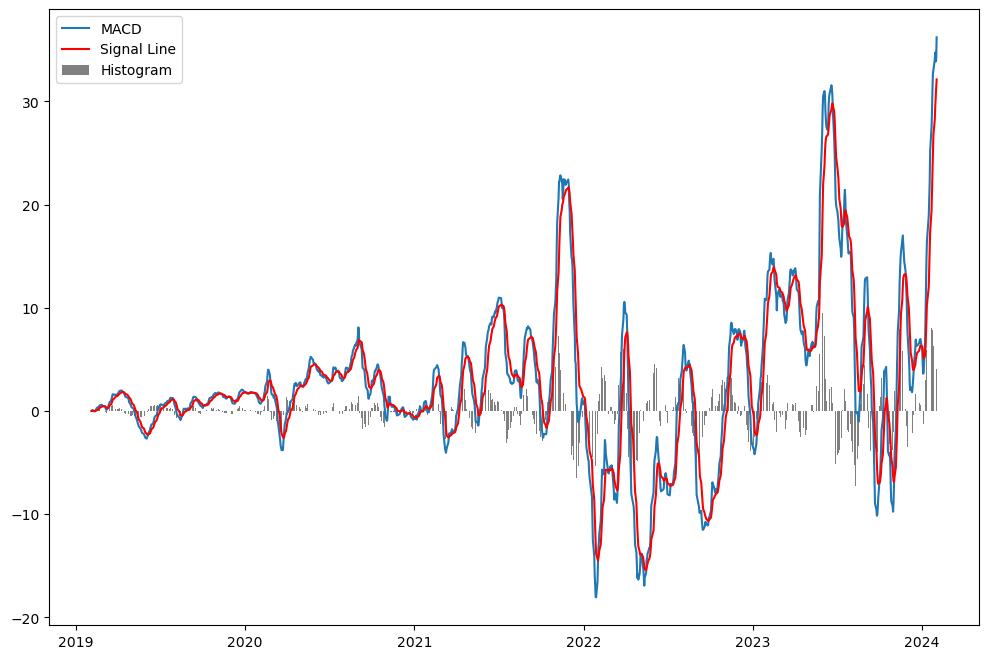

In [48]:


df['EMA_12'] = df['Price'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Price'].ewm(span=26, adjust=False).mean()

# MACD line is the difference between the 12-day EMA and the 26-day EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal EMA is the 9-day EMA of the MACD line
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Histogram is the difference between the MACD line and the Signal line
df['Histogram'] = df['MACD'] - df['Signal_Line']

# Plot the chart
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['MACD'], label='MACD')
plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
plt.bar(df.index, df['Histogram'], label='Histogram', color='gray')
plt.legend()
plt.show()

In [54]:
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1154 entries, 2019-06-12 to 2024-02-02
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1154 non-null   float64
 1   Volume                 1154 non-null   float64
 2   Timestamp              1154 non-null   float64
 3   Trading_value          1154 non-null   float64
 4   Daily_Return           1154 non-null   float64
 5   30D MA                 1154 non-null   float64
 6   60D MA                 1154 non-null   float64
 7   90D MA                 1154 non-null   float64
 8   Uper Band              1154 non-null   float64
 9   Lower Band             1154 non-null   float64
 10  RSI                    1154 non-null   float64
 11  Normalized_Volatility  1154 non-null   float64
 12  VWAP                   1154 non-null   float64
 13  EMA_12                 1154 non-null   float64
 14  EMA_26                 1154 non-null  

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = df['Timestamp'].values.reshape(-1, 1)
y = df['Price'].values

# Chia dữ liệu thành dữ liệu huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Huấn luyện mô hình học máy truyền thống, chẳng hạn như Hồi quy Tuyến tính
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Huấn luyện mô hình Rừng Ngẫu nhiên
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Tính toán dự đoán từ mỗi mô hình
linear_preds = linear_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Kết hợp các dự đoán từ mỗi mô hình để có được dự đoán lai
combined_preds = (linear_preds + rf_preds) / 2

# Đánh giá hiệu suất của mô hình lai
hybrid_mse = mean_squared_error(y_test, combined_preds)
print(f'Hybrid Model MSE: {hybrid_mse}')

Hybrid Model MSE: 1281.2343660611998


In [66]:
combined_preds=pd.DataFrame(linear_preds)
combined_preds.head(10)

,0
0,218.178584
1,156.178351
2,229.770883
3,225.767357
4,131.945975
5,399.494768
6,66.066300
7,202.724062
8,120.022663
9,142.262385


<Axes: >

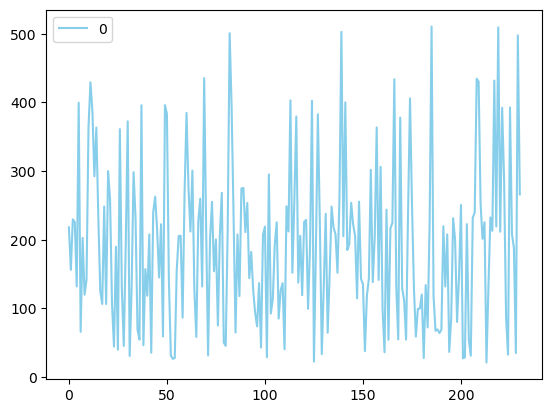

In [59]:
combined_preds.plot.line(color='skyblue')